In [1]:
from pathlib import Path
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import matplotlib

sns.set_style("whitegrid")
sns.set_palette("colorblind")
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

orig_inst_set = "../DACBench/dacbench/instance_sets/sigmoid/sigmoid_2D3M_train.csv"
path = Path("../data/instance_sets/selected/generated/Sigmoid/2D3M_train")
print(path.resolve())
fnames = list(path.glob("**/*.csv"))

mapper = {
    0: "instance_id",
    1: "shift_0",
    2: "slope_0",
    3: "shift_1",
    4: "slope_1",
}

D = []
for fname in fnames:
    metadata = dict(
        benchmark_id = fname.parts[-9],
        instance_set = fname.parts[-8],
        selected_on = fname.parts[-7],
        selection_method = fname.parts[-6],
        feature_type = fname.parts[-5],
        source_features = fname.parts[-4],
        threshold = fname.parts[-3],
        seed = fname.parts[-2],
        selector_run = fname.parts[-1].split("_")[-1].split(".")[0],
        instance_set_id = "_".join(fname.parts[-6:])[:-4]
    )
    instances = pd.read_csv(fname, header=None)

    instances = instances.rename(mapper=mapper, axis="columns")
    for k, v in metadata.items():
        instances[k] = v
    D.append(instances)
df = pd.concat(D).reset_index(drop=True)
df["origin"] = "selector"
del D

orig_df = pd.read_csv(orig_inst_set, header=None).rename(mapper=mapper, axis="columns")
orig_df["origin"] = "full"
orig_df["instance_set_id"] = "full"
df = pd.concat([df, orig_df]).reset_index(drop=True)
print(df["instance_set_id"].unique())

/home/numina/Documents/repos/instance-dac/data/instance_sets/selected/generated/Sigmoid/2D3M_train
['MIS_Raw_AI_0.95_2_2' 'MIS_Raw_AI_0.95_2_1' 'MIS_Raw_AI_0.95_2_4' ...
 'DS_Catch22_I_0.9_1_3' 'DS_Catch22_I_0.9_1_5' 'full']


In [2]:
def _sig(x, scaling, inflection):
    """Simple sigmoid function"""
    return 1 / (1 + np.exp(-scaling * (x - inflection)))

def get_sig_inst_feat_df(df: pd.DataFrame, action_dim: int = 0) -> pd.DataFrame:
    X = np.linspace(0, 10, 100)
    Y = np.concatenate(df.apply(lambda x: _sig(X, x[f"slope_{action_dim}"], x[f"shift_{action_dim}"]), axis="columns").to_numpy())
    X_ = np.concatenate([X] * len(df))
    X_.shape
    origin = ["train"] * len(X) * int(0.5*len(df)) + ["test"] * len(X) * int(0.5*len(df)) 
    D = pd.DataFrame({
        "x": X_,
        "y": Y,
        "origin": np.concatenate(df["origin"].apply(lambda x: [x] * len(X)).to_numpy()),
        "action_dim": action_dim,
        "id": np.concatenate([[i] * len(X) for i in range(len(df))]),
    })
    return D

In [3]:
groups = ["selection_method", "feature_type", "source_features", "threshold", "seed", "selector_run"]

for gid, gdf in df.groupby(groups):   
    n_instances = len(orig_df)
    n_selected = gdf["instance_id"].nunique()
    # fig, ax = plt.subplots()
    # gdf = pd.concat([orig_df, gdf]).reset_index(drop=True)
    # ax = sns.scatterplot(data=gdf, x="shift_0", y="slope_0", hue="origin", style="origin", ax=ax)
    # ax.set_title(str(gid) + f" {n_selected/n_instances:.4f}")
    # # ax = sns.scatterplot(data=df, x="shift_1", y="slope_1", marker="o", hue="origin", ax=ax)
    # plt.show()

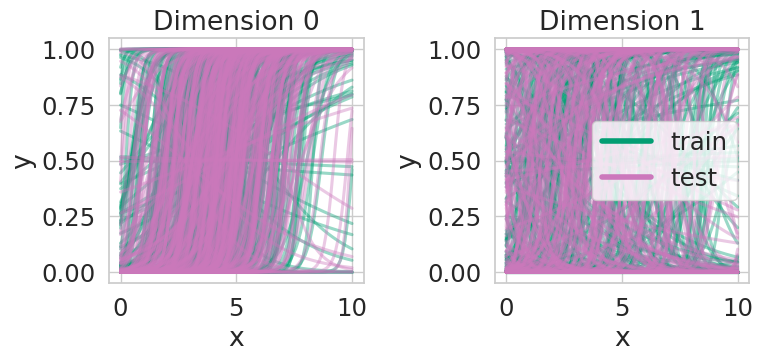

In [4]:
# Train and test instance sets
import numpy as np
import itertools

sns.set(font_scale=1.4)
sns.set_style("whitegrid")
sns.set_palette("colorblind")
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

set_train = pd.read_csv("../DACBench/dacbench/instance_sets/sigmoid/sigmoid_2D3M_train.csv", header=None).rename(mapper=mapper, axis="columns")
set_train["origin"] = "train"
set_test = pd.read_csv("../DACBench/dacbench/instance_sets/sigmoid/sigmoid_2D3M_test.csv", header=None).rename(mapper=mapper, axis="columns")
set_test["origin"] = "test"
df_ = pd.concat([set_train, set_test])

# fig = plt.figure(figsize=(8,3))
# d = 2
# axes = fig.subplots(nrows=1, ncols=d)
# for i in range(d):
#     ax = axes[i]
#     ax = sns.scatterplot(data=df, x=f"shift_{i}", y=f"slope_{i}", hue="origin", ax=ax)
#     ax.legend(title=None)
#     if i == 0:
#         ax.get_legend().remove()

# fig.set_tight_layout(True)
# fig.savefig("sigmoid_train_test_space.pdf", dpi=300, bbox_inches="tight")
# plt.show()


from matplotlib.lines import Line2D

cmap = sns.color_palette("colorblind", as_cmap=True)

custom_lines = [Line2D([0], [0], color=cmap[2], lw=4),
                Line2D([0], [0], color=cmap[4], lw=4),
]
palette = {
    "train": cmap[2],
    "test": cmap[4],
}

D = pd.concat([get_sig_inst_feat_df(df_, 0), get_sig_inst_feat_df(df_, 1)]).reset_index(drop=True)


sns.set(font_scale=1.6)
sns.set_style("whitegrid")
sns.set_palette("colorblind")

fig = plt.figure(figsize=(8,4))
axes = fig.subplots(ncols=2)
for i, ax in enumerate(axes):
    ax = sns.lineplot(data=D[D["action_dim"]==i], x="x", y="y", hue="origin", style="id", alpha=0.4, dashes=False, ax=ax, lw=2.2, palette=palette)
    ax.legend(title=None)
    hand, labl = ax.get_legend_handles_labels()
    handout=[]
    lablout=[]
    for h,l in zip(hand,labl):
        if l in D["origin"].unique():
            lablout.append(l)
            handout.append(h)
    ax.legend(custom_lines, lablout)
    if i == 0:
        ax.get_legend().remove()
    ax.set_title(f"Dimension {i}", )#fontdict=dict(fontsize=10))
fig.set_tight_layout(True)
fig.savefig("sigmoid_train_test_instances.pdf", bbox_inches="tight", dpi=300)
plt.show()


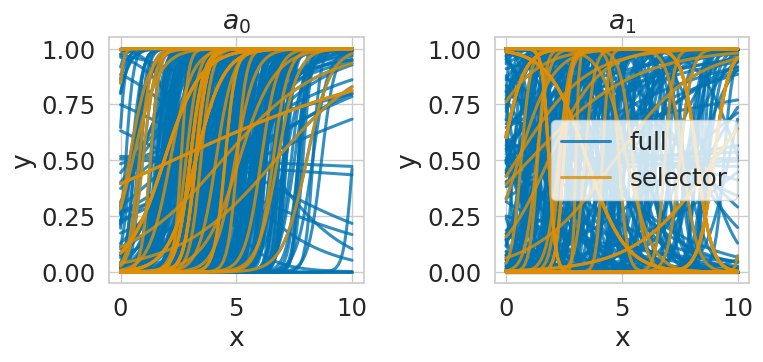

In [5]:
def read_iset(path: str | Path) -> pd.DataFrame:
    return pd.read_csv(path, header=None).rename(mapper=mapper, axis="columns")

# selectors = {
    
# }
# D = pd.concat([get_sig_inst_feat_df(read_iset(p), o) for o, p in selectors.items()]).reset_index(drop=True)
# D = get_sig_inst_feat_df(df)

best_selector = "MIS_Catch22_R_0.7"
D = df[(df["instance_set_id"] == "full") | df["instance_set_id"].str.startswith(best_selector)]
D = pd.concat([get_sig_inst_feat_df(D,0), get_sig_inst_feat_df(D,1)]).reset_index(drop=True)


sns.set(font_scale=1.6)
sns.set_style("whitegrid")
sns.set_palette("colorblind")
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

D.sort_values(by="origin", inplace=True)

fig = plt.figure(figsize=(8,4))
axes = fig.subplots(ncols=2)
for i, ax in enumerate(axes):
    ax = sns.lineplot(data=D[D["action_dim"]==i], x="x", y="y", hue="origin", style="id", alpha=0.8, dashes=False, ax=ax, lw=2.2)
    ax.legend(title=None)
    ax.get_legend().remove()
    if i != 0:
        hand, labl = ax.get_legend_handles_labels()
        handout=[]
        lablout=[]
        for h,l in zip(hand,labl):
            if l in D["origin"].unique():
                lablout.append(l)
                handout.append(h)
        ax.legend(handout, lablout)
    ax.set_title(f"$a_{i}$", )
fig.set_tight_layout(True)
fig.savefig("sigmoid_selector_instances.pdf", bbox_inches="tight", dpi=300)
plt.show()

# fig = plt.figure(figsize=(7,4))
# axes = fig.subplots(ncols=2)
# for i, ax in enumerate(axes):
#     ax = sns.scatterplot(
#         data=D,
#         x=f"slope_{i}", y=f"shift_{i}", hue="origin", style="origin", alpha=1, 
#         s=55,
#         markers={
#             "full": "o",
#             "selector": "X",
#         },
#         ax=ax
#         )
#     ax.legend(title=None)
#     if i == 0:
#         ax.get_legend().remove()
# # ax.get_legend().remove()
# # hand, labl = ax.get_legend_handles_labels()
# # handout=[]
# # lablout=[]
# # for h,l in zip(hand,labl):
# #     if l in D["origin"].unique():
# #         lablout.append(l)
# #         handout.append(h)
# # ax.legend(handout, lablout)
# # ax.get_legend().remove()
# fig.set_tight_layout(True)
# fig.savefig("sigmoid_selector_instances.pdf", bbox_inches="tight", dpi=300)
# plt.show()